In [1]:
import numbers
from collections import Counter
from scipy.stats import mode
from sklearn.utils import _safe_indexing
from sklearn.utils._param_validation import HasMethods, Interval, StrOptions
import pandas as pd
import numpy as np
import seaborn as sns    
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import (f1_score, roc_auc_score, average_precision_score, 
                             accuracy_score, matthews_corrcoef, recall_score, 
                             precision_score, confusion_matrix)

In [2]:
df = pd.read_csv('D:/My Thesis/data in spss/imputed_Extra_tree .csv')
df = df.drop('ID' ,axis = 1)

In [3]:
X=df.drop('Hospital_outcome',axis=1)
y=df['Hospital_outcome']

In [4]:
categorical_features = ['Sex','Digestive_underlying', 'Respiratory_underlying','Infectious_underlying','Fatness_underlying', 'Urinary_underlying',
'Diabete_underlying', 'Highbloodpressure_underlying','Heart_underlying','Nervous_underlying', 'Blooddisease_underlying','Opiate', 'Education', 
'Urinary', 'Urinary_Incontinence', 'Previous_recurrent', 'Noconsious', 'GCS','Receivingblood', 'Conciousness', 'Patient_arrival', 'Time',
'Type_stroke', 'Treatment_method', 'Pneumonia', 'Convulsions','Individual', 'Motionless','Respiratory', 'Heart', 'Edema', 'Bloody',
'Vision_impairment', 'Sensory', 'Headache', 'Blurred_Vision','Reduce_strength_limb', 'Lackofbalance', 'Weakness', 'Delirium','Skin_problems',
'Aphasia_and_Dysarthria', 'Cranial_nerve_Disorder','Paralyzed', 'Digestive_problems']  # Replace with your categorical column names
numeric_features = ['Age','RR','HR','systolic','Lengthofhospitalization']
df[categorical_features] = df[categorical_features].astype('category')

In [5]:
# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=101
)

# OneHotEncoder

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])

In [7]:
from sklearn.ensemble import IsolationForest
# Outlier detection (on training data only)
outlier_detector = IsolationForest(contamination=0.05, random_state=101)
outliers = outlier_detector.fit_predict(preprocessor.fit_transform(X_train))
inlier_mask = outliers != -1

In [8]:
# Apply outlier removal
X_train_clean, y_train_clean = X_train.iloc[inlier_mask], y_train.iloc[inlier_mask]

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import issparse  # For sparse matrix check
# Initialize ENN
enn = EditedNearestNeighbours(
    n_neighbors=3,       # Check 3 nearest neighbors (default)
    kind_sel='all',      # Remove if ALL neighbors disagree ('mode' for majority vote)
    sampling_strategy='auto'  # Targets majority class (0)
)
X_train_res, y_train_res = enn.fit_resample(X_train_preprocessed, y_train_clean)

In [9]:
# Preprocess cleaned training data
X_train_preprocessed = preprocessor.transform(X_train_clean)

In [14]:
print("Class distribution before ENN:", Counter(y_train))
print("Class distribution after ENN:", Counter(y_train_res))

Class distribution before ENN: Counter({0: 1605, 1: 315})
Class distribution after ENN: Counter({0: 1287, 1: 264})


# Create SVM-REEN Model

In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
svm_model = SVC(probability=True, random_state=101)
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf','poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'probability': [True],  # Must be True for predict_proba()
     'degree' : [1,2,3]
}

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1,verbose=1)
grid_search.fit(X_train_res, y_train_res)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'C': 10, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}


In [16]:
svm_model = SVC(C=10,
    kernel='rbf',
    degree=1,
    gamma=0.1,probability=True, random_state=101) 
svm_model.fit(X_train_res, y_train_res )

SVC(C=10, degree=1, gamma=0.1, probability=True, random_state=101)

In [17]:
# Evaluate on test set
X_test_preprocessed = preprocessor.transform(X_test)

In [18]:
y_pred = svm_model.predict(X_test_preprocessed)
svm_probs = svm_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)

In [19]:
# Evaluate best model REEN
accuracy = accuracy_score(y_test, y_pred)
print("\nOptimized Test Accuracy:",accuracy)


Optimized Test Accuracy: 0.866504854368932


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [21]:
# Convert confusion matrix to percentages
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100

In [22]:
# Print confusion matrix (counts)
print("Confusion Matrix (Counts):")
print(cm)

Confusion Matrix (Counts):
[[625  64]
 [ 46  89]]


In [23]:
# Print confusion matrix (percentages)
print("\nConfusion Matrix (Percentages):")
print(cm_percent)


Confusion Matrix (Percentages):
[[90.71117562  9.28882438]
 [34.07407407 65.92592593]]


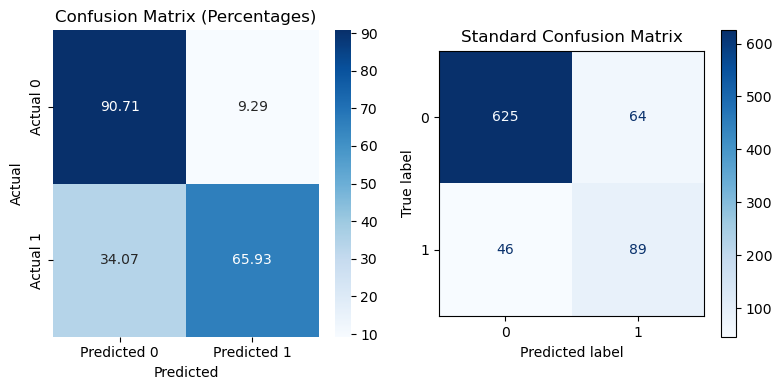

In [24]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# First plot: Percentage confusion matrix (Seaborn)
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix (Percentages)')

# Second plot: Standard confusion matrix (Scikit-learn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=svm_model.classes_)
disp.plot(cmap='Blues', ax=ax2)
ax2.set_title('Standard Confusion Matrix')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [25]:
# Calculate and print the error rate and the number of misclassifications
err = 1 - accuracy_score(y_test, y_pred)
n_miss = np.sum(y_pred != y_test)
print(f"Error Rate: {err}")
print(f"Number of Misclassifications: {n_miss}")

Error Rate: 0.133495145631068
Number of Misclassifications: 110


In [26]:
from sklearn.metrics import classification_report
# Generate classification report 
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       689
           1       0.58      0.66      0.62       135

    accuracy                           0.87       824
   macro avg       0.76      0.78      0.77       824
weighted avg       0.87      0.87      0.87       824



In [27]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import matthews_corrcoef
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = np.sqrt(sensitivity * specificity)
f1_score = f1_score(y_test, y_pred)
# Print results
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"G-mean: {g_mean:.3f}")
print(f"F1_measure: {f1_score:.3f}")
print(f"MCC: {mcc:.3f}")

Sensitivity (Recall): 0.659
Specificity: 0.907
G-mean: 0.773
F1_measure: 0.618
MCC: 0.539


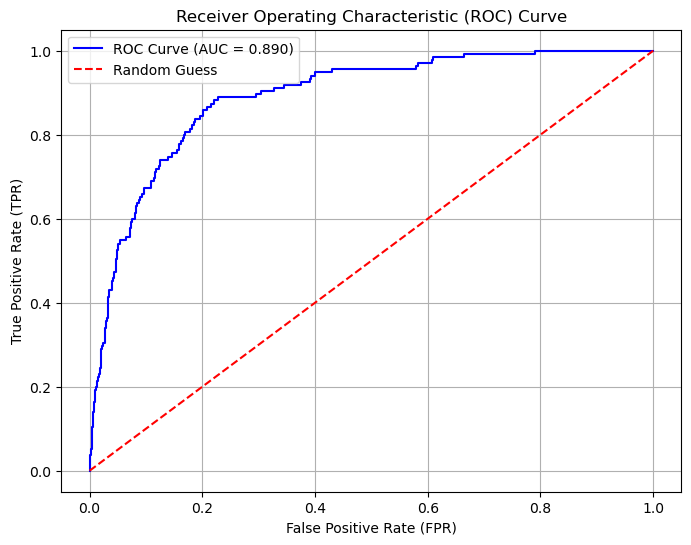

AUCROC: 0.890


In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
# Get predicted probabilities for positive class
svm_probs = svm_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)
fpr, tpr, thresholds = roc_curve(y_test, svm_probs, pos_label=svm_model.classes_[1])
# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, svm_probs)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the AUC score
print(f'AUCROC: {auc:.3f}')

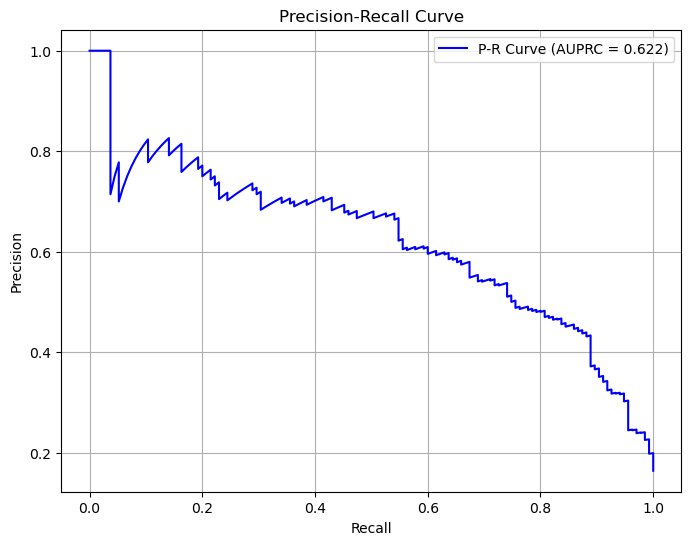

AUPRC: 0.622


In [29]:
from sklearn.metrics import precision_recall_curve, auc
# Get predicted probabilities for the positive class
svm_probs = svm_model.predict_proba(X_test_preprocessed)[:, 1]   # For scikit-learn models
# For Keras: y_probs = model.predict(X_test).flatten()
# Calculate P-R curve
precision, recall, thresholds = precision_recall_curve(y_test, svm_probs)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'P-R Curve (AUPRC = {pr_auc:.3f})',color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the pr-auc score
print(f'AUPRC: {pr_auc:.3f}')